# Inspecting complicated models

When models get complicated, inspecting the parameters and their relationships gets a bit clunky. This notebook offers a couple of prototypes to address this:

 - A LinearTied class that provides a handy repr showing the linear relationship. 
   - This lets `model.tied` show the relationship rather than just a pointer to a user-defined function
   - A timing test shows no significant performance hit for this convenience
 - A `tabulate_model` function to show the results and the constraints in tabular form by putting them in an astropy table. 
 
This is illustrated using the example from the 'Tied Constraints' section of the latest documentation https://docs.astropy.org/en/latest/modeling/example-fitting-constraints.html.  

In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.utils.data import get_pkg_data_filename
from astropy.io import ascii
from astropy.modeling import models, fitting

In [2]:
%matplotlib inline

Get the data.

In [3]:
#fname = get_pkg_data_filename('data/spec.txt', package='astropy.modeling.tests')
fname=('spec.txt')
spec = ascii.read(fname)
wave = spec['lambda']
flux = spec['flux']

## Class to create a linear relationship between to a parameter

In [4]:
class LinearTied(object):
    """ Tie two variables associated by a linear relation:
           derived_param = factor * param + offset
        
        Parameters
        ----------
        model : Astropy.modeling FittableModel instance
            The model
        param : string
            The name of the first parameter
        factor : float64
            The multiplicative factor to apply
        offset : float64
            The additive offset to apply
    """
    def __init__(self, model,param,factor=1.,offset=0.,fmt=".3g"):
        self.param_name = param
        idx = model.param_names.index(param)
        self.param = model.parameters[idx]
        self.factor = factor
        self.offset = offset
        factor_fstring = "" if factor == 1. else f"{self.factor:{fmt}} * "
        offset_fstring = "" if offset == 0. else f" + {self.offset:{fmt}}"
        self.output_string = factor_fstring + f"{self.param_name}" + offset_fstring
    def __call__(self,model):
        return self.param*self.factor+self.offset
    def __repr__(self):
            return self.output_string

Use the rest wavelengths of known lines as initial values for the fit.

In [5]:
Hbeta = 4862.721
OIII_1 = 4958.911
OIII_2 = 5008.239

Create Gaussian1D models for each of the Hbeta and OIII lines.

In [6]:
h_beta = models.Gaussian1D(amplitude=34, mean=Hbeta, stddev=5,name='Hbeta')
o3_2 = models.Gaussian1D(amplitude=170, mean=OIII_2, stddev=5,name='[OIII]4959')
o3_1 = models.Gaussian1D(amplitude=57, mean=OIII_1, stddev=5,name='[OIII]5007')

Tie the ratio of the intensity of the two OIII lines.

In [7]:
def tie_ampl(model):
    return model.amplitude_2 / 3.1

o3_1.amplitude.tied = tie_ampl

Also tie the wavelength of the Hbeta line to the OIII wavelength.

In [8]:
def tie_wave(model):
    return model.mean_0 * OIII_1 / Hbeta

o3_1.mean.tied = tie_wave

Create a Polynomial model to fit the continuum.

In [9]:
mean_flux = flux.mean()
cont = np.where(flux > mean_flux, mean_flux, flux)
linfitter = fitting.LinearLSQFitter()
poly_cont = linfitter(models.Polynomial1D(1,name='continuum'), wave, cont)

Create a compound model for the three lines and the continuum.

In [10]:
hbeta_combo = h_beta + o3_1 + o3_2 + poly_cont

Inspect the tied parameters. The information on how the parameters are tied together is buried.

In [11]:
hbeta_combo.tied

{'amplitude_0': False,
 'mean_0': False,
 'stddev_0': False,
 'amplitude_1': <function __main__.tie_ampl(model)>,
 'mean_1': <function __main__.tie_wave(model)>,
 'stddev_1': False,
 'amplitude_2': False,
 'mean_2': False,
 'stddev_2': False,
 'c0_3': False,
 'c1_3': False}

Tie them with the `LinearTied` class.

In [12]:
hbeta_combo.amplitude_1.tied = LinearTied(hbeta_combo,'amplitude_2',factor=1./3.1)
hbeta_combo.mean_1.tied = LinearTied(hbeta_combo,'mean_0',factor=OIII_1 / Hbeta)

Inspect the tied parameters. The relationship is now visible.

In [13]:
hbeta_combo.tied

{'amplitude_0': False,
 'mean_0': False,
 'stddev_0': False,
 'amplitude_1': 0.323 * amplitude_2,
 'mean_1': 1.02 * mean_0,
 'stddev_1': False,
 'amplitude_2': False,
 'mean_2': False,
 'stddev_2': False,
 'c0_3': False,
 'c1_3': False}

Fit all lines simultaneously.

In [14]:
fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(hbeta_combo, wave, flux)
fitted_lines = fitted_model(wave)

Plot the results

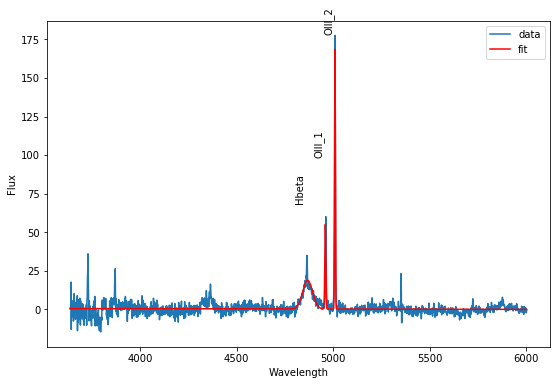

In [15]:
fig = plt.figure(figsize=(9, 6))
p = plt.plot(wave, flux, label="data")
p = plt.plot(wave, fitted_lines, 'r', label="fit")
p = plt.legend()
p = plt.xlabel("Wavelength")
p = plt.ylabel("Flux")
t = plt.text(4800, 70, 'Hbeta', rotation=90)
t = plt.text(4900, 100, 'OIII_1', rotation=90)
t = plt.text(4950, 180, 'OIII_2', rotation=90)

In [16]:
def tabulate_model(model):
    column_names = ['parameter','submodel','class','subparam','value',
                    'fixed?','lower','upper','tie']
    parameter = model.param_names
    submodelnumber = [model._param_map[p][0] for p in parameter]
    submodelname = np.array(model.submodel_names)[submodelnumber]
    smclass = [model._get_submodels()[i] for i in submodelnumber]
    submodelclass = [sm.__class__.__name__ for sm in smclass]
    subparam = [model._param_map[p][1] for p in parameter]
    value = fitted_model.parameters
    fixed = [fitted_model.fixed[p] for p in parameter]
    lower = [fitted_model.bounds[p][0] for p in parameter]
    upper = [fitted_model.bounds[p][1] for p in parameter]
    tied = [fitted_model.tied[p] for p in parameter]
    t = Table([parameter,submodelname,submodelclass,subparam,value,
               fixed,lower,upper,tied],names=column_names)
    return t

In [17]:
tabulate_model(fitted_model)

parameter,submodel,class,subparam,value,fixed?,lower,upper,tie
str11,str10,str12,str9,float64,bool,object,object,object
amplitude_0,Hbeta,Gaussian1D,amplitude,18.594550385482794,False,None,None,False
mean_0,Hbeta,Gaussian1D,mean,4867.310072331513,False,None,None,False
stddev_0,Hbeta,Gaussian1D,stddev,25.282296877948678,False,1.1754943508222875e-38,None,False
amplitude_1,[OIII]5007,Gaussian1D,amplitude,54.83870967741935,False,None,None,0.323 * amplitude_2
mean_1,[OIII]5007,Gaussian1D,mean,4958.911,False,None,None,1.02 * mean_0
stddev_1,[OIII]5007,Gaussian1D,stddev,2.7057123406280716,False,1.1754943508222875e-38,None,False
amplitude_2,[OIII]4959,Gaussian1D,amplitude,172.06914525664476,False,None,None,False
mean_2,[OIII]4959,Gaussian1D,mean,5009.0248595102,False,None,None,False
stddev_2,[OIII]4959,Gaussian1D,stddev,2.0058422376807776,False,1.1754943508222875e-38,None,False


## Timing test

Revert to original defintion (ties are custom functions) and time the fitting

In [18]:
hbeta_combo = h_beta + o3_1 + o3_2 + poly_cont

In [19]:
%%timeit
fitted_model = fitter(hbeta_combo, wave, flux)

105 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
hbeta_combo.amplitude_1.tied = LinearTied(hbeta_combo,'amplitude_2',1./3.1)
hbeta_combo.mean_1.tied = LinearTied(hbeta_combo,'mean_0',OIII_1 / Hbeta)

In [21]:
%%timeit
fitted_model = fitter(hbeta_combo, wave, flux)

97.7 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
